# Семинар №3

In [1]:
import numpy as np
import cv2 
import skimage.exposure
import skimage.io
import matplotlib.pyplot as plt
from pathlib import Path

plt.style.use('seaborn')
%matplotlib inline

In [2]:
# вспомогательная функция
def plot_transform_result(src_image, transform_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение и его преобразование.
    
    :param src_image: np.ndarray: исходное изображение
    :param transform_image: np.ndarray: преобразованное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    plt.figure(figsize=(6.4 * 2, 4.8 * 2), constrained_layout=True)

    cmap = 'gray' if is_gray else None
    
    plt.subplot(121)
    plt.imshow(src_image, cmap=cmap)
    plt.axis('off'), plt.title('Исходное изображение')
    
    plt.subplot(122)
    plt.imshow(transform_image, cmap=cmap)
    plt.axis('off'), plt.title('Результат преобразования')
    
    plt.show()

# Гистограммы 

Так что такое гистограмма? Вы можете рассматривать гистограмму как график, который дает вам общее представление о распределении интенсивности изображения. Это график со значениями пикселей (от $0$ до $255$, не всегда) по оси $X$ и соответствующим количеством пикселей в изображении по оси $Y$.

Это просто еще один способ понять образ. Глядя на гистограмму изображения, вы получаете представление о контрасте, яркости, распределении интенсивности и т.д. этого изображения. Почти все инструменты обработки изображений сегодня предоставляют функции на гистограмме.

<img src="https://i.ibb.co/cJxrWhx/histogram_sample.jpg" alt="Drawing" style="width: 400px;"/>

Вы можете увидеть изображение и его гистограмму. Помните, эта гистограмма нарисована для изображения в оттенках серого, а не для цветного изображения. Левая область гистограммы показывает количество темных пикселей на изображении, а правая область показывает количество ярких пикселей. На гистограмме видно, что темная область больше, чем яркая, а количество полутонов (значения пикселей в среднем диапазоне, скажем, около $127$) намного меньше, чем остального.

**Гистограммы** $-$ это данные, организованные в набор предопределенных столбцов.
Когда мы говорим данные, не ограничиваем их значениями интенсивности (как мы видели в предыдущем уроке). Собранные данные могут быть любой функцией, которую вы найдете полезной для описания изображения.

Посмотрим на пример. Представьте, что матрица содержит информацию об изображении (то есть интенсивность в диапазоне $0-255$):

<img src="img/Histogram_Calculation_Theory_Hist.jpg" alt="Drawing" style="width: 400px;"/>

Что произойдет, если мы захотим считать эти данные организованным способом? Так как мы знаем, что диапазон информационных значений, для этого случая равен [0, 256], можем сегментировать наш диапазон по частям (называемым ячейками), например:

$$
{\begin{array}{l}
[0, 255] = { [0, 15] \cup [16, 31] \cup ....\cup [240,255] } \\
range = { bin_{1} \cup bin_{2} \cup ....\cup bin_{n = 15} }
\end{array}}
$$

и можем вести подсчет количества пикселей, попадающих в диапазон каждого $bin_{i}$. Применяя это к примеру выше, мы получаем изображение ниже (ось x представляет ячейки, а ось y – количество пикселей в каждом из них).

<img src="https://i.ibb.co/Wss2Fqh/Histogram_Calculation_Theory_Hist1.jpg" alt="Drawing" style="width: 400px;"/>

Это был простой пример того, как работает гистограмма и почему она полезна. Гистограмма может вести учет не только интенсивности цвета, но и любых характеристик изображения, которые мы хотим измерить (то есть градиенты, направления и т.д.).

Выделим части гистограммы:

* __dims__: количество параметров, для которых вы хотите собрать данные. В нашем примере dims = $1$, потому что мы рассчитываем только значения интенсивности каждого пикселя (в полутоновом изображении)
* __bins__: это количество подразделений в каждом тусклом свете. В нашем примере bins = $16$
* __range__: пределы измеряемых значений. В этом случае: range = $[0,255]$

Что если вы хотите сосчитать две особенности? В этом случае ваша результирующая гистограмма будет трехмерным графиком (в котором $x$ и $y$ будут $bin_{x}$ и $bin_{y}$ для каждого объекта, а $z$ будет количеством отсчетов для каждой комбинации $(bin_ {x}, bin_ {y})$. То же самое относится и к дополнительным функциям (конечно, это становится сложнее).

## Гистограммы в OpenCV

Воспользуемся функцией ```cv2.calcHist()```, чтобы найти гистограмму. Ознакомимся с функцией и ее параметрами:

```cv2.calcHist (image, channel, mask, histSize, range , hist, accumulate)```

* **images** $-$ это исходное изображение типа $uint8$ или $float32$. его следует указывать в квадратных скобках, т.е. **[img]**.
* **channel** $-$ также указывается в квадратных скобках. Это индекс канала, для которого мы рассчитываем гистограмму. Например, если входное изображение представляет собой изображение в градациях серого, его значение равно $[0]$. Для цветного изображения вы можете передать $[0]$, $[1]$ или $[2]$, чтобы вычислить гистограмму синего, зеленого или красного канала соответственно.
* **mask** $-$ маска изображения. Чтобы найти гистограмму полного изображения, она задается как **None**. Но если вы хотите найти гистограмму определенной области изображения, вы должны создать для нее изображение маски и указать ее как маску.
* **histSize** $-$ это представляет наш счетчик __bin__. Нужно указывать в квадратных скобках. Для полной шкалы мы передаем $[256]$.
* **range** $-$ это наш **range**. Обычно это $[0,256]$.
* **hist** $-$ выходная гистограмма, представляющая собой плотный или разреженный размерный массив.
* **accumulate** $-$ накопительный флаг. Если он установлен, гистограмма не очищается в начале при выделении. Эта функция позволяет вычислять одну гистограмму из нескольких наборов массивов или своевременно обновлять гистограмму.

In [3]:
image = cv2.imread('img/forest.jpg')
h, w, _ = image.shape
image = cv2.resize(image.copy(), (w // 2, h // 2))
image = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)

# grayscale
gray = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2GRAY)

In [4]:
image.shape, h, w

((540, 960, 3), 1080, 1920)

In [5]:
# получим гистограмму
# ravel() - разворачивает массив в список
hist = cv2.calcHist([gray.ravel()], [0], None, [256], [0, 256])

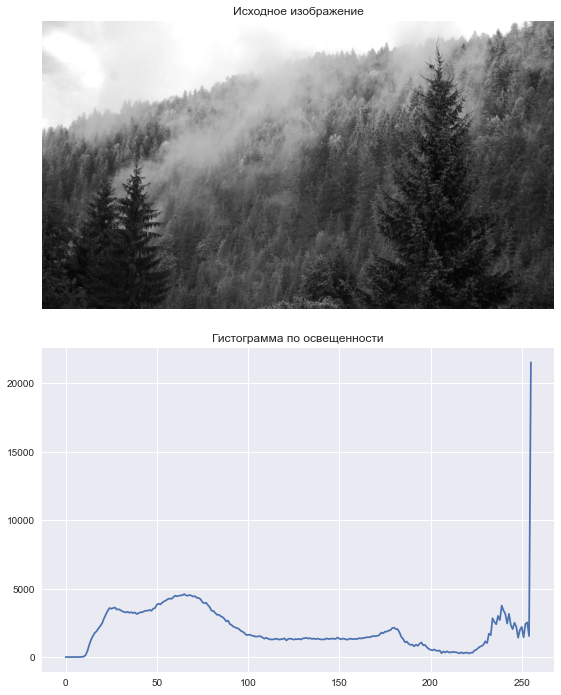

In [6]:
plt.figure(figsize=(6.4 * 1.2, 4.8 * 2), constrained_layout=True)

plt.subplot(211)
plt.imshow(gray, cmap='gray'),
plt.axis('off'), plt.title('Исходное изображение')

plt.subplot(212)
plt.plot(hist)
plt.title('Гистограмма по освещенности')

plt.show()

## Гистограммы в  Numpy

```Numpy``` также предоставляет вам функцию ```np.histogram()```.

In [7]:
hist_np, bins = np.histogram(gray.ravel(), 256, [0,256])

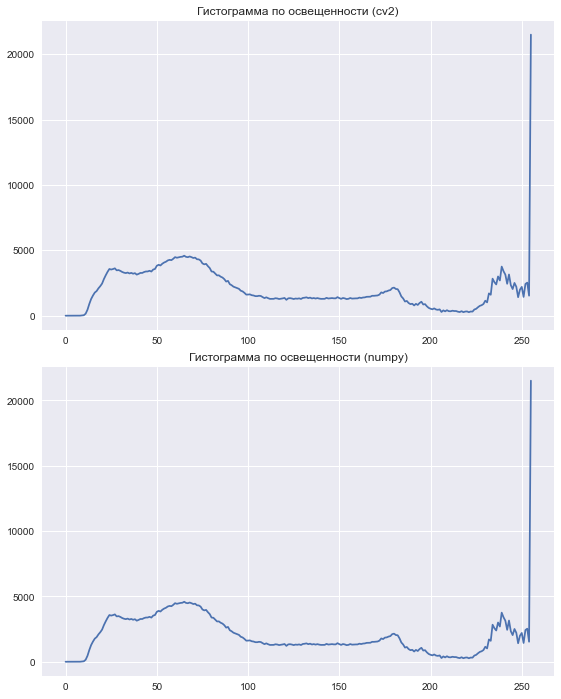

In [8]:
plt.figure(figsize=(6.4 * 1.2, 4.8 * 2), constrained_layout=True)

plt.subplot(211)
plt.plot(hist)
plt.title('Гистограмма по освещенности (cv2)')

plt.subplot(212)
plt.plot(hist_np)
plt.title('Гистограмма по освещенности (numpy)')

plt.show()

Гистограмма аналогичная, как мы рассчитывали ранее. Но ячейки будут иметь $257$ элементов, потому что **Numpy** рассчитывает ячейки как $0-0.99$, $1-1.99$, $2-2.99$ и т.д. Таким образом, конечный диапазон будет $255-255.99$. Чтобы представить это, они также добавляют $256$ в конце bins. Но нам не нужно это $256$. До $255$ достаточно.

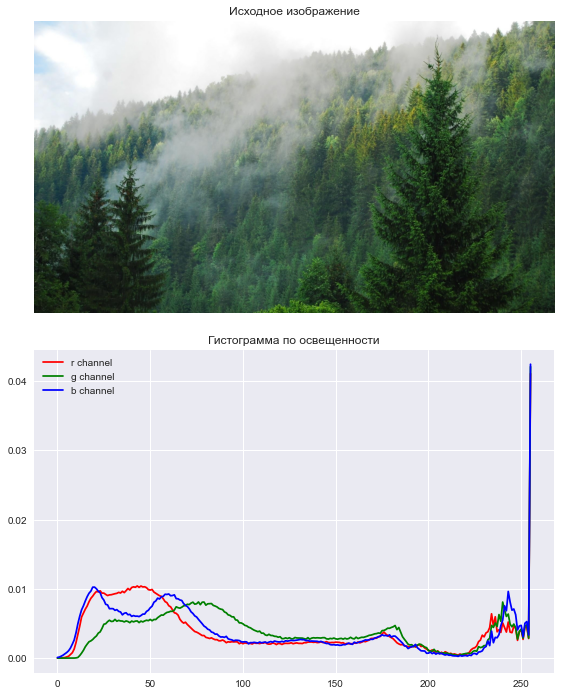

In [9]:
# Визуализируем сразу 3 канала цвета

plt.figure(figsize=(6.4 * 1.2, 4.8 * 2), constrained_layout=True)

plt.subplot(211)
plt.imshow(image)
plt.title('Исходное изображение'), plt.axis('off')

color = ('r', 'g', 'b')
plt.subplot(212)

for i, col in enumerate(color):
    hist, bins = np.histogram(image[..., i].ravel(), 256, [0, 256])
    norm_const = image.shape[0] * image.shape[1]    
    plt.plot(hist / norm_const, color=col, label=f'{col} channel')
    
plt.title('Гистограмма по освещенности')
plt.legend()    

plt.show()

## Применение маски

Мы использовали ```cv2.calcHist()```, чтобы найти гистограмму полного изображения. Что если вы хотите найти гистограммы некоторых областей изображения? Просто создайте изображение маски белым цветом на области, где вы хотите найти гистограмму, и черным в противном случае. Затем передайте это как маску.

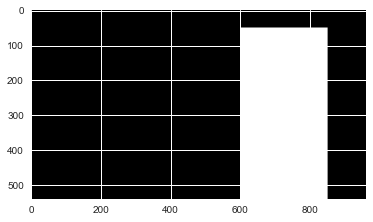

In [10]:
# grayscale
gray = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2GRAY)

# создадим маску
mask = np.zeros(image.shape[:2], np.uint8)
mask[50:, 600:850] = 1

plt.imshow(mask, cmap='gray')
plt.show()

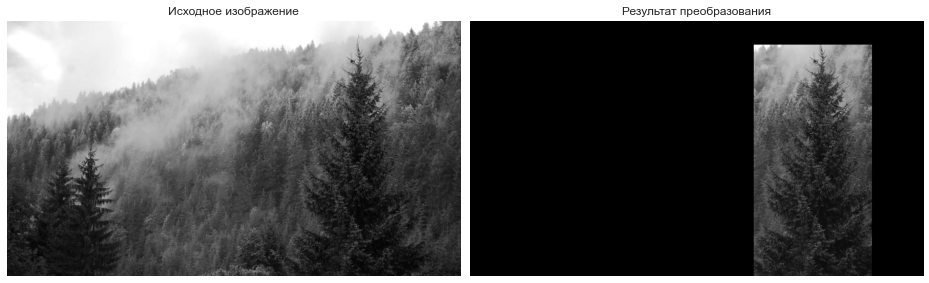

In [11]:
masked_img = cv2.bitwise_and(gray, gray, mask=mask)

plot_transform_result(gray, masked_img, is_gray=True)

Тут мы воспользовались распространенным приемом с *"маской"*, т.е. использовали массив из нулей, на которой наложили интересующую картнику. 

Для арифметических операция над матрицами в OpenCV есть несклько базовых функций. Рассмотрим несколько из них:

* __cv2.absdiff(src1, src2[,dst])__

    абсолютная разница между двумя массивами: $${\texttt{dst}(I)=|\texttt{src1}(I)-\texttt{src2}(I)|}$$

* __cv2.add(src1, src2[, dst[, mask[, dtype]]])__

    Функция add рассчитывае сумму двух массивов: $${\texttt{dst}(I)=\texttt{src1}(I)+\texttt{src2}(I) \quad\texttt{if mask}(I)\ne0}$$

* __cv2.bitwise_and(src1, src2[, dst[, mask]])__

    Функция рассчитывает побитовое логическое соединение для каждого элемента массива: $${\texttt{dst} (I)=\texttt{src1}(I)\wedge\texttt{src2}(I)\quad\texttt{if mask}(I)\ne0}$$

* __cv2.bitwise_not(src[, dst[, mask]])__

    Функция рассчитывает побитовую инверсию входного массива для каждого элемента: $${\texttt{dst}(I)=\neg{\texttt{src}(I)}}$$

* __cv2.bitwise_or(src1, src2[, dst[, mask]])__

    Функция вычисляет побитовую логическую дизъюнкцию для каждого элемента для: $${\texttt{dst}(I)=\texttt{src1}(I)\vee\texttt{src2}(I)\quad\texttt{if mask}(I)\ne0}$$

* __cv2.bitwise_xor(src1, src2[, dst[, mask]])__

    Функция вычисляет побитовую логическую операцию «исключая или» для каждого элемента массива: $${\texttt{dst}(I)=\texttt{src1}(I)\oplus\texttt{src2}(I)\quad\texttt{if mask}(I)\ne0}$$

Остальные можно найти в [документации](https://docs.opencv.org/3.4.2/d2/de8/group__core__array.html)

In [12]:
## посчитаем гистограмму для всего изображения и маски
hist_full = cv2.calcHist([gray], [0], None, [256], [0,256])
hist_mask = cv2.calcHist([gray], [0], mask, [256], [0,256])

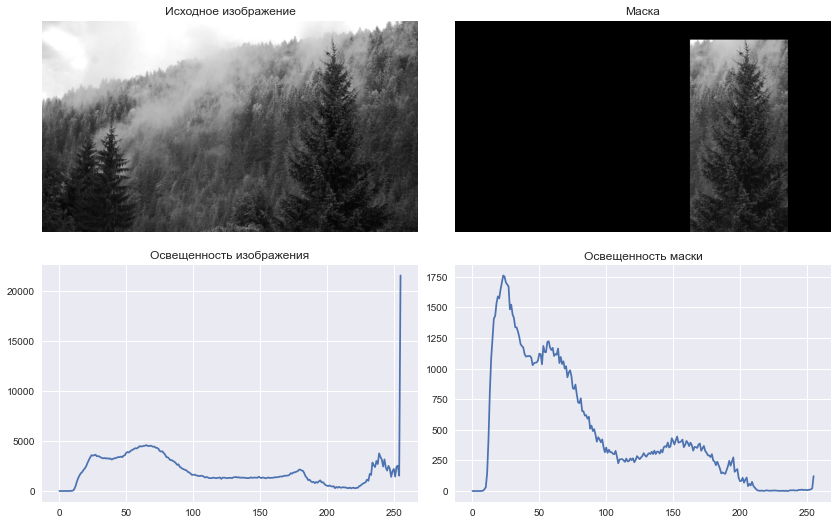

In [13]:
plt.figure(figsize=(6.4 * 1.8, 4.8 * 1.5), constrained_layout=True)

plt.subplot(221)
plt.title('Исходное изображение')
plt.imshow(gray, cmap='gray')
plt.axis('off')

plt.subplot(222)
plt.title('Маска')
plt.imshow(masked_img, cmap='gray')
plt.axis('off')

plt.subplot(223)
plt.title('Освещенность изображения')
plt.plot(hist_full)

plt.subplot(224)
plt.title('Освещенность маски')
plt.plot(hist_mask)

plt.show()

Теперь посмотрим для всех каналов цвета интесивность на маске.

In [14]:
masked_img = cv2.bitwise_and(image, image, mask=mask)

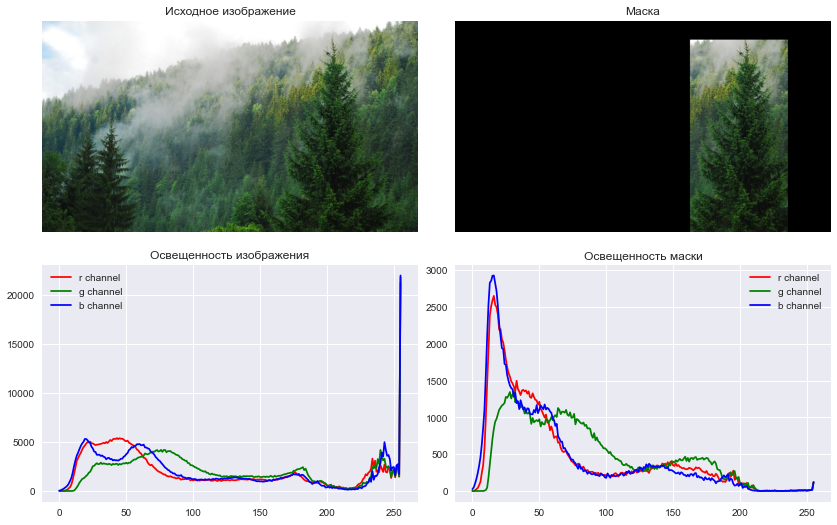

In [15]:
plt.figure(figsize=(6.4 * 1.8, 4.8 * 1.5), constrained_layout=True)

plt.subplot(221)
plt.title('Исходное изображение')
plt.imshow(image)
plt.axis('off')

plt.subplot(222)
plt.title('Маска')
plt.imshow(masked_img)
plt.axis('off')

color = ('r', 'g', 'b')
for i,col in enumerate(color):
    plt.subplot(223)
    hist_full = cv2.calcHist([image], [i], None, [256], [0,256])
    plt.plot(hist_full, color=col, label=f'{col} channel')
    
    plt.subplot(224)
    hist_mask = cv2.calcHist([image], [i], mask, [256], [0,256])
    plt.plot(hist_mask, color=col, label=f'{col} channel')


plt.subplot(223), plt.title('Освещенность изображения'), plt.legend()
plt.subplot(224), plt.title('Освещенность маски'), plt.legend()

plt.show()

## Выравнивание гистограм

OpenCV имеет функцию для этого, ```cv2.equalizeHist()```. Его вход $-$ это изображение в градациях серого, а выход – изображение, выровненное по гистограмме. Однако, реализация в ```cv2``` выполняется медленнее, чем ```Numpy```.

## Выравнивание гистограмм с помощью skimage

Этот пример улучшает изображение с низким контрастом, используя метод, называемый выравниванием гистограммы, который «распределяет наиболее частые значения интенсивности». Выровненное изображение имеет примерно линейную кумулятивную функцию распределения.

In [16]:
# Equalization
img_eq = skimage.exposure.equalize_hist(image)
img_eq = (img_eq * 255).astype(np.uint8)

c:\Max\Anaconda\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


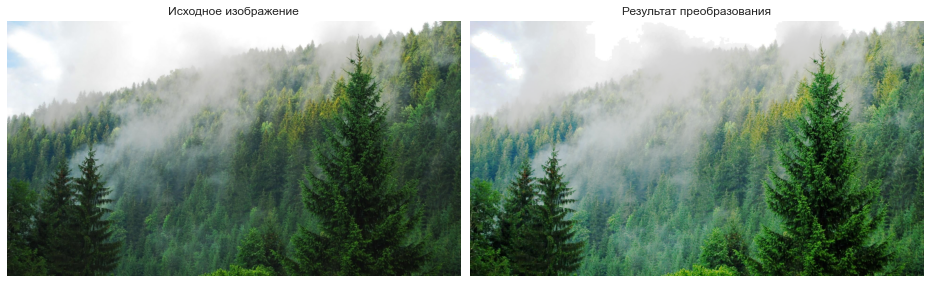

In [17]:
plot_transform_result(image, img_eq)

In [ ]:
plt.figure(figsize=(6.4 * 2, 4.8 * 1), constrained_layout=True)

color = ('r', 'g', 'b')
for i,col in enumerate(color):
    plt.subplot(121)
    hist_full = cv2.calcHist([image], [i], None, [256], [0,256])
    plt.plot(hist_full, color=col, label=f'{col} channel')
    
    plt.subplot(122)
    hist_full = cv2.calcHist([img_eq], [i], None, [256], [0,256])
    plt.plot(hist_full, color=col, label=f'{col} channel')


plt.subplot(121), plt.title('Освещенность исходного изображения'), plt.legend()
plt.subplot(122), plt.title('Освещенность преобразованного изображения'), plt.legend()

plt.show()

In [ ]:
# Adaptive Equalization
img_adapteq = skimage.exposure.equalize_adapthist(image, kernel_size=(200,200), clip_limit=0.03)
img_adapteq = (img_adapteq * 255).astype(np.uint8)

In [ ]:
plot_transform_result(image, img_adapteq)

In [ ]:
plt.figure(figsize=(6.4 * 2, 4.8 * 1), constrained_layout=False)

color = ('r', 'g', 'b')
for i,col in enumerate(color):
    plt.subplot(121)
    hist_full = cv2.calcHist([image], [i], None, [256], [0,256])
    plt.plot(hist_full, color=col, label=f'{col} channel')
    
    plt.subplot(122)
    hist_full = cv2.calcHist([img_adapteq], [i], None, [256], [0,256])
    plt.plot(hist_full, color=col, label=f'{col} channel')


plt.subplot(121), plt.title('Освещенность исходного изображения'), plt.legend()
plt.subplot(122), plt.title('Освещенность преобразованного изображения'), plt.legend()

plt.show()

## Сопоставление гистограмм

Этот пример демонстрирует функцию сопоставления гистограмм. Он манипулирует пикселями входного изображения, чтобы его гистограмма соответствовала гистограмме эталонного изображения. Если изображения имеют несколько каналов, сопоставление выполняется независимо для каждого канала, пока количество каналов равно во входном изображении и эталонном.

Сопоставление гистограммы можно использовать в качестве упрощенной нормализации для обработки изображений, например сопоставления признаков, особенно в обстоятельствах, когда изображения были взяты из разных источников или в разных условиях (например, при освещении).

In [ ]:
image = skimage.io.imread('img/forest.jpg')
reference = skimage.io.imread('img/forest_ex.jpg')

match = skimage.exposure.match_histograms(image, reference, multichannel=True)

In [ ]:
plt.figure(figsize=(6.4 * 3, 4.8 * 1), constrained_layout=True)

plt.subplot(131)
plt.title('image изображение')
plt.imshow(image)
plt.axis('off')

plt.subplot(132)
plt.title('База для преобразования')
plt.imshow(reference)
plt.axis('off')

plt.subplot(133)
plt.title('Результат преобразования')
plt.imshow(match)
plt.axis('off')

plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(6.4 * 3, 4.8 * 2), constrained_layout=True)

for i, img in enumerate((image, reference, match)):
    for c, c_color in enumerate(('red', 'green', 'blue')):
        img_hist, bins = skimage.exposure.histogram(img[..., c], source_range='dtype')
        axes[c, i].plot(bins, img_hist / img_hist.max(), color=c_color)
        
        img_cdf, bins = skimage.exposure.cumulative_distribution(img[..., c])
        axes[c, i].plot(bins, img_cdf, color='black')
        axes[c, 0].set_ylabel(c_color)

axes[0, 0].set_title('Source')
axes[0, 1].set_title('Reference')
axes[0, 2].set_title('Matched')

plt.show()

## Сравнение гистограмм 

Пользы от гистограмм не будет, если их не сравнивать с эталоннами. Предположим, есть эталонное изображение $-$ какой-то объект заданных размеров. Также есть множество неизвестных изображений, на которых нужно найти эталонное изображение. Для этого нужно перебирать участки изображений, сравнивая содержимое с эталоном. Можно сравнивать каждую точку из участка, но это будет медленно. Гораздо быстрее по ресурсам $-$ это сравнить гистограммы яркости. Для сравнения гистограмм в OpenCV предусмотрена функция ```cv2.CompareHist()```.

Мы рассмотрим только несколько метрик для сравнения: 

1. __Correlation__ (```method=cv2.HISTCMP_CORREL```)

$d(H_1,H_2) =  \frac{\sum_I (H_1(I) - \bar{H_1}) (H_2(I) - \bar{H_2})}{\sqrt{\sum_I(H_1(I) - \bar{H_1})^2 \sum_I(H_2(I) - \bar{H_2})^2}}$, где $\bar{H_k} =  \frac{1}{N} \sum _J H_k(J)$

2. __Chi-Square__ (```method=cv2.HISTCMP_CHISQR```)

$d(H_1,H_2) =  \sum _I  \frac{\left(H_1(I)-H_2(I)\right)^2}{H_1(I)}$

3. __Intersection__ (```method=cv2.HISTCMP_INTERSECT```)

$d(H_1,H_2) =  1 - \sum _I  \min (H_1(I), H_2(I))$

4. __Bhattacharyya distance__ (```method=cv2.HISTCMP_BHATTACHARYYA```).

$d(H_1,H_2) =  \sqrt{1 - \frac{1}{\sqrt{\bar{H_1} \bar{H_2} N^2}} \sum_I \sqrt{H_1(I) \cdot H_2(I)}}$

In [ ]:
carpet = cv2.imread('img/carpet_ex.jpg')
carpet_gray = cv2.cvtColor(carpet, cv2.COLOR_BGR2GRAY)
forest = cv2.imread('img/forest_ex.jpg')
forest_gray = cv2.cvtColor(forest, cv2.COLOR_BGR2GRAY)

hist_carpet = cv2.calcHist([carpet_gray.ravel()], [0], None, [256], [0,256])
hist_forest = cv2.calcHist([forest_gray.ravel()], [0], None, [256], [0,256])

In [ ]:
hist_carpet /= hist_carpet.max()
hist_forest /= hist_forest.max()

In [ ]:
plt.figure(figsize=(6.4 * 2, 4.8), constrained_layout=True)

plt.subplot(121)
plt.title('Первое изображение')
plt.imshow(carpet_gray, cmap='gray')
plt.axis('off')

plt.subplot(122)
plt.title('Второе изображение')
plt.imshow(forest_gray, cmap='gray')
plt.axis('off')

plt.show()

In [ ]:
# возьмем выравненные гистограммы освещенности и сравним через корреляцию

cor_1 = cv2.compareHist(hist_carpet, hist_forest, cv2.HISTCMP_CORREL)

cor_2 = cv2.compareHist(hist_carpet, hist_forest, cv2.HISTCMP_INTERSECT) / np.sum(hist_carpet)

cor_3 = cv2.compareHist(hist_carpet, hist_forest, cv2.HISTCMP_BHATTACHARYYA)


print(f'Correlation: {cor_1:.3f}\n'
      f'Intersection: {cor_2:.3f}\n'
      f'Bhattacharyya: {cor_3:.3f}')

In [ ]:
plt.figure(figsize=(6.4 * 2, 4.8), constrained_layout=True)

plt.plot(hist_carpet, color='r')
plt.plot(hist_forest, color='gray')

plt.show()

###  Другой пример

Рассмотрим изображения, которая семантически больше похожи друг на друга.

In [ ]:
another_forest = cv2.imread('img/forest.jpg')
another_forest = cv2.cvtColor(another_forest, cv2.COLOR_BGR2RGB)

forest = cv2.imread('img/forest_ex.jpg')
forest = cv2.cvtColor(forest, cv2.COLOR_BGR2RGB)

In [ ]:
plt.figure(figsize=(6.4 * 2, 4.8), constrained_layout=True)

plt.subplot(121)
plt.title('Первое изображение')
plt.imshow(another_forest, cmap='gray')
plt.axis('off')

plt.subplot(122)
plt.title('Второе изображение')
plt.imshow(forest, cmap='gray')
plt.axis('off')

plt.show()

Рассмотрим один канал и части изображений.

In [ ]:
another_forest_g = another_forest[100:, 900:, 1]  # выделим один канал
forest_g = forest[:300, :, 1]  # выделим один канал

hist_another_forest = cv2.calcHist([another_forest_g.ravel()], [0], None, [256], [0,256])
hist_forest = cv2.calcHist([forest_g.ravel()], [0], None, [256], [0,256])

In [ ]:
# нормировка гистограмм
hist_another_forest /= hist_another_forest.max()
hist_forest /= hist_forest.max()

In [ ]:
plt.figure(figsize=(6.4 * 2, 4.8), constrained_layout=True)

plt.subplot(121)
plt.title('Первое изображение')
plt.imshow(another_forest_g, cmap='gray')
plt.axis('off')

plt.subplot(122)
plt.title('Второе изображение')
plt.imshow(forest_g, cmap='gray')
plt.axis('off')

plt.show()

In [ ]:
# возьмем выравненные гистограммы освещенности и сравним через корреляцию

cor_1 = cv2.compareHist(hist_another_forest, hist_forest, cv2.HISTCMP_CORREL)

cor_2 = cv2.compareHist(hist_another_forest, hist_forest, cv2.HISTCMP_INTERSECT) / np.sum(hist_another_forest)

cor_3 = cv2.compareHist(hist_another_forest, hist_forest, cv2.HISTCMP_BHATTACHARYYA)

In [ ]:
print(f'Correlation: {cor_1:.3f}\n'
      f'Intersection: {cor_2:.3f}\n'
      f'Bhattacharyya: {cor_3:.3f}')

In [ ]:
plt.figure(figsize=(6.4 * 2, 4.8), constrained_layout=True)

plt.plot(hist_another_forest, color='r')
plt.plot(hist_forest, color='gray')

plt.show()

Заметьте, что в качестве примера были выбраны близкие гистограммы, по сути одна, но с разными операциями выравнивания. Вариативность применения коэффициента корреляции зависит от вашей фантазии и возможности интерпретировать результат.

**Помните**, что корреляция показывает только **линейную** зависимость двух случайных величин. Порой связь может быть гораздо сложнее.

Разберём на примере самый простой случай классификации, когда пространство признака одномерное, а нам нужно разделить 2 класса. Ситуация встречается чаще, чем может представиться: например, когда нужно отличить два сигнала, или сравнить паттерн с образцом. Пусть у нас есть обучающая выборка. При этом получается изображение, где по оси X будет мера похожести, а по оси Y -количество событий с такой мерой. Когда искомый объект похож на себя — получается левая гауссиана. Когда не похож — правая. Значение X=0.4 разделяет выборки так, что ошибочное решение минимизирует вероятность принятия любого неправильного решения. Именно поиском такого разделителя и является задача классификации.

<img src="https://i.ibb.co/gdG3jGj/hist_comp.png" alt="Drawing" style="width: 500px;"/>

# Выравнивание цвета изображений 

Коррекция (Enhancement) предназначена для того, чтобы сделать изображение более подходящим, чем оригинал, для конкретного применения.
Метод гамма-коррекции полезен, когда необходимо изменить контрастность и яркость изображения.
Чтобы понять, что такое гамма-коррекция, сначала нужно разобраться в преобразовании Power Law Transformation. С входными изображениями f(x, y) и после преобразования T у нас есть увеличенное выходное изображение g(x, y): $g(x, y) = T[ f(x, y) ]$

Если обозначить r, s как серый уровень f(x, y) и g(x, y) для любой точки (x, y), то формулу можно записать как:

<img src="img/Chart-5.jpg" alt="Drawing" style="width: 500px;"/>

## Контраст изоражений

Контраст изображения достигается за счет смещения верхних и нижних значений изображения, как показано на рисунке ниже.

<img src="img/Chart-2.jpg" alt="Drawing" style="width: 300px;"/>

In [ ]:
# Contrast stretching
image = cv2.imread('img/sudoku.jpg')

p_l = np.percentile(image, 2)
p_h = np.percentile(image, 95)
image_rescale = skimage.exposure.rescale_intensity(image, in_range=(p_l, p_h))

plot_transform_result(image, image_rescale)

In [ ]:
hist, bins = np.histogram(image.flatten(), 256, [0,256])
hist_rescale, bins = np.histogram(image_rescale.flatten(), 256, [0,256])

In [ ]:
plt.figure(figsize=(6.4 * 2, 4.8), constrained_layout=True)

plt.subplot(121)
plt.title('Исходная гистограмма')
plt.plot(hist)

plt.subplot(122)
plt.title('Результат преобразования')
plt.plot(hist_rescale)

plt.show()

## Гамма коррекция 

Для повышения яркости изображения мы изменим значение r, чтобы достичь значения s. Для выполнения работы определено преобразование: $s = c*r^y$

Вышеуказанное преобразование использует r power γ (гамма), поэтому оно называется преобразованием Power Law Transformation. Изменяя значение γ, мы получаем разные результаты. Поэтому гамма-коррекция - это процесс выбора наилучшего значения, чтобы гамма имела наилучшее выходное изображение.

<img src="img/Chart-6.jpg" alt="Drawing" style="width: 700px;"/>

In [ ]:
# Gamma correction
gamma_corrected = skimage.exposure.adjust_gamma(image, gamma=0.5)

plot_transform_result(image, gamma_corrected)

In [ ]:
hist, bins = np.histogram(image.flatten(), 256, [0,256])
hist_rescale, bins = np.histogram(gamma_corrected.flatten(), 256, [0,256])

In [ ]:
plt.figure(figsize=(6.4 * 2, 4.8), constrained_layout=True)

plt.subplot(121)
plt.title('Исходная гистограмма')
plt.plot(hist)

plt.subplot(122)
plt.title('Результат преобразования')
plt.plot(hist_rescale)

plt.show()

## Логарифмическая коррекция

Преобразование по логарифму.

In [ ]:
# Logarithmic
logarithmic_corrected = skimage.exposure.adjust_log(image, gain=0.7)

plot_transform_result(image, logarithmic_corrected)

In [ ]:
hist, bins = np.histogram(image.flatten(), 256, [0,256])
hist_rescale, bins = np.histogram(logarithmic_corrected.flatten(), 256, [0,256])

In [ ]:
plt.figure(figsize=(6.4 * 2, 4.8), constrained_layout=True)

plt.subplot(121)
plt.title('Исходная гистограмма')
plt.plot(hist)

plt.subplot(122)
plt.title('Результат преобразования')
plt.plot(hist_rescale)

plt.show()

## CLAHE

Первое выравнивание гистограммы, которое мы только что видели, учитывает глобальный контраст изображения. Во многих случаях это не очень хорошая идея. Например, ниже изображение показывает входное изображение и его результат после глобальной выравнивания гистограммы.

In [ ]:
## вспомним, что было с линиаризацией освещенности
image = cv2.imread('img/forest.jpg')
gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
global_corrected_image = cv2.equalizeHist(gray)

plot_transform_result(gray, global_corrected_image, is_gray=True)

Контрастность фона улучшилась после выравнивания гистограммы. Мы потеряли большую часть информации там из-за чрезмерной яркости. Это потому, что его гистограмма не ограничена определенной областью, как мы видели в предыдущих случаях.

Поэтому для решения этой проблемы используется __адаптивное выравнивание гистограммы (AHE)__. При этом изображение делится на маленькие блоки, называемые «плитками» (tileSize по умолчанию в OpenCV составляет $8\times8$). Затем каждый из этих блоков гистограммы выравнивается как обычно. Таким образом, в небольшой области гистограмма будет ограничена небольшой областью (если нет шума), как показано на рисунке:

<img src="https://i.ibb.co/Z2v37jw/AHE-neighbourhoods.png" alt="Drawing" style="width: 300px;"/>

Если шум есть, он будет усилен. Чтобы избежать этого, применяется ограничение контраста. Если какой-либо интервал гистограммы превышает указанный предел контраста (по умолчанию $40$ в OpenCV), эти пиксели обрезаются и распределяются равномерно по другим интервалам перед применением выравнивания гистограммы. После выравнивания для удаления артефактов на границах мозаики применяется билинейная интерполяция.

Ниже приведен фрагмент кода, демонстрирующий применение CLAHE в OpenCV:

In [ ]:
# применим CLAHE из cv2 и сравним результат с обычным варвниваем всей гистрограммы
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe_image = clahe.apply(gray)

In [ ]:
hist_gray = cv2.calcHist([gray], [0], None, [256], [0,256])
hist_equ = cv2.calcHist([global_corrected_image], [0], None, [256], [0,256])
hist_clahe = cv2.calcHist([clahe_image], [0], None, [256], [0,256])

In [ ]:
plt.figure(figsize=(6.4 * 3, 4.8 * 1.7), constrained_layout=True)

plt.subplot(231)
plt.title('Исходное изображение')
plt.imshow(gray, cmap='gray'), plt.axis('off')

plt.subplot(232)
plt.title('Результат глобальной коррекции гистограммы')
plt.imshow(global_corrected_image, cmap='gray'), plt.axis('off')

plt.subplot(233)
plt.title('Результат коррекции с помощью CLAHE')
plt.imshow(clahe_image, cmap='gray'), plt.axis('off')

plt.subplot(234)
plt.plot(hist_gray)

plt.subplot(235)
plt.plot(hist_equ)

plt.subplot(236)
plt.plot(hist_clahe)


plt.show()

# Бинаризация изображений
Здесь все просто. Если значение пикселя больше порогового значения, ему присваивается одно значение (может быть белым), в противном случае ему присваивается другое значение (может быть черным). Используемая функция **cv2.threshold(src, thresh, maxval, type)**

* **src** $-$ исходное изображение, которое должно быть изображением в градациях серого
* **thresh** $-$ пороговое значение, которое используется для классификации значений пикселей
* **maxval** $-$ представляет значение, которое будет дано, если значение пикселя больше (иногда меньше) порогового значения
* **type** $-$ предоставляет различные стили порогового значения.

Различные типы:
1. cv2.THRESH_BINARY
2. cv2.THRESH_BINARY_INV
3. cv2.THRESH_TRUNC
4. cv2.THRESH_TOZERO
5. cv2.THRESH_TOZERO_INV

На выходе функция возвращает два значения. Первый $-$ **retval**, которое будет объяснено позже. Второй $-$ **thresholded image**.

Подробнее в [документации](https://docs.opencv.org/3.4.2/d7/d1b/group__imgproc__misc.html#gae8a4a146d1ca78c626a53577199e9c57).

Рассмотрим разные типы threshold на примере градиента серого цвета.

In [ ]:
img = cv2.imread('img/grad_grayscale.png')

In [ ]:
ret, thresh1 = cv2.threshold(img, 127, 255, cv2.TbHRESH_BINARY)
ret, thresh2 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
ret, thresh3 = cv2.threshold(img, 127, 255, cv2.THRESH_TRUNC)
ret, thresh4 = cv2.threshold(img, 127, 255, cv2.THRESH_TOZERO)
ret, thresh5 = cv2.threshold(img, 127, 255, cv2.THRESH_TOZERO_INV)


titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]
plt.figure(figsize=(6.4, 4.8), constrained_layout=True)
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
    
plt.show()

## Adaptive Thresholding
В предыдущем разделе мы использовали глобальное значение в качестве порогового значения. Но это может быть не хорошо во всех условиях, когда изображение имеет разные условия освещения в разных областях. В этом случае мы идем на адаптивный порог. При этом алгоритм вычисляет порог для небольших областей изображения. Таким образом, мы получаем разные пороговые значения для разных областей одного и того же изображения, и это дает нам лучшие результаты для изображений с разной освещенностью.

Он имеет три «специальных» входных параметра и только один выходной аргумент.

Адаптивный метод $-$ **cv2.adaptiveThreshold(src, maxValue, adaptiveMethod, thresholdType, blockSize, C)** - решает, как рассчитывается пороговое значение.

* **thresholdType**:
    * *cv2.ADAPTIVE_THRESH_MEAN_C*: пороговое значение является средним значением области соседства.

    * *cv2.ADAPTIVE_THRESH_GAUSSIAN_C*: пороговое значение представляет собой взвешенную сумму значений окрестностей, где веса представляют собой гауссово окно.

* **blockSize** $-$ определяет размер окна.

* **C** $-$ это константа, которая вычитается из вычисленного среднего или взвешенного среднего.

Ниже приведен фрагмент кода, сравнивающий глобальные пороги и адаптивные пороги для изображения с различным освещением:

In [ ]:
img = cv2.imread('img/sudoku.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [ ]:
img = cv2.medianBlur(img, 5)

ret, th1 = cv2.threshold(img, 127, 255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
th3 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

In [ ]:
titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]
plt.figure(figsize=(6.4 * 2, 4.8 * 2), constrained_layout=True)

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.axis('off')
    
plt.show()

## Бинаризация Оцу
В первом разделе я говорил вам, что есть второй параметр retVal. Его использование происходит, когда мы идем на бинаризацию Оцу. Так что же это?

В глобальном пороговом значении мы использовали произвольное значение для порогового значения, верно? Итак, как мы можем знать, что выбранное нами значение является хорошим или нет? Ответ, метод проб и ошибок. Но рассмотрим бимодальное изображение (проще говоря, бимодальное изображение - это изображение, гистограмма которого имеет два пика). Для этого изображения мы можем приблизительно принять значение в середине этих пиков в качестве порогового значения, верно? Это то, что делает бинаризация Оцу. Таким образом, простыми словами, он автоматически вычисляет пороговое значение из гистограммы изображения для бимодального изображения. (Для изображений, которые не являются бимодальными, бинаризация не будет точной.)

Для этого используется наша функция **cv2.threshold()**, но передается дополнительный флаг *cv2.THRESH_OTSU*. Для порогового значения просто введите ноль. Затем алгоритм находит оптимальное пороговое значение и возвращает вас в качестве второго выхода retVal. Если пороговое значение Otsu не используется, **retVal** соответствует пороговому значению, которое вы использовали.

Проверьте ниже пример. Входное изображение является шумным изображением. В первом случае я применил глобальный порог для значения $127$. Во втором случае я применил порог Оцу напрямую. В третьем случае я отфильтровал изображение с гауссовым ядром $5\times5$, чтобы удалить шум, затем применил пороговое значение Оцу. Посмотрите, как фильтрация шума улучшает результат.

In [ ]:
img = cv2.imread('img/otsu_ex.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [ ]:
plt.imshow(img)

In [ ]:
# внесем случайный шум
noise_img = img.copy()
mask = np.random.randint(0, 2, size=noise_img.shape).astype(bool)
r = np.random.rand(*noise_img.shape) * np.max(noise_img)
noise_img[mask] = r[mask]
img = noise_img

In [ ]:
# global thresholding
ret1, th1 = cv2.threshold(img, 170, 255, cv2.THRESH_BINARY)

# Otsu's thresholding
ret2, th2 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img, (5,5), 0)
ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

In [ ]:
# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]
ret = [ret1, ret2, ret3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (th=170)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]

plt.figure(figsize=(6.4 * 2, 4.8 * 2), constrained_layout=True)

for i in range(3):
    plt.subplot(3, 3, i * 3 + 1), plt.imshow(images[i*3],'gray')
    plt.title(titles[i * 3]), plt.axis('off')
    
    plt.subplot(3, 3, i * 3 + 2), plt.hist(images[i*3].ravel(), 256)
    plt.title(titles[i * 3 + 1] + ', threshold = ' + str(ret[i]))
    
    plt.subplot(3, 3, i * 3 + 3), plt.imshow(images[i*3 + 2],'gray')
    plt.title(titles[i * 3 + 2]), plt.axis('off')
plt.show()

## Пример с цветокоррекцией



In [ ]:
img = cv2.imread('img/sudoku.jpg')

In [ ]:
img_msrcp = retinex.MSRCP(
    img,
    config['sigma_list'],
    config['low_clip'],
    config['high_clip']        
)  

In [ ]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

ret, th1 = cv2.threshold(img, 127, 255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
th3 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

In [ ]:
titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img_msrcp, th1, th2, th3]
plt.figure(figsize=(6.4 * 2, 4.8 * 2), constrained_layout=True)

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i],'gray')
    plt.title(titles[i]), plt.axis('off')
    
plt.show()

# Морфологические трансформации
Морфологические преобразования $-$ это простые операции, основанные на форме изображения. Обычно это выполняется на двоичных изображениях. Он требует двух входных данных, один из которых является нашим исходным изображением, второй называется структурирующим элементом или ядром, которое определяет характер операции. Два основных морфологических оператора - это **эрозия** и **растягивание**. Затем его разновидности, такие как открытие, закрытие, градиент и т. д.

**Эрозия** (размывание/сужение) изображения обычно используется для избавления от случайных вкраплений на изображении. Идея состоит в том, что вкрапления при размывании устранятся, тогда как крупные и соответсвенно более визуально-значимые регионы остаются.

**Растягивание** (расширение) же, по идее, так же должно устранять шум и способствовать объединению областей изображения, которые были разделены шумом, тенями.
Применение же небольшого растягивания должно сплавить эти области в одну.

Морфологические операции, чаще всего, применяются над двоичными изображениями, которые получаются после порогового преобразования (thresholding).
***
**Подробнее с математической морфологией можно ознакомиться по этим ссылка: [1](https://ru.wikipedia.org/wiki/%CC%E0%F2%E5%EC%E0%F2%E8%F7%E5%F1%EA%E0%FF_%EC%EE%F0%F4%EE%EB%EE%E3%E8%FF), [2](https://habr.com/post/113626/), [3](http://wiki.technicalvision.ru/index.php/%D0%9C%D0%BE%D1%80%D1%84%D0%BE%D0%BB%D0%BE%D0%B3%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B5_%D0%BE%D0%BF%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D0%B8_%D0%BD%D0%B0_%D0%B1%D0%B8%D0%BD%D0%B0%D1%80%D0%BD%D1%8B%D1%85_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D1%8F%D1%85).**

## Эрозия

Основная идея эрозии похожа только на эрозию почвы, она размывает границы объекта переднего плана (всегда старайтесь, чтобы передний план оставался белым). Так, что это делает? Ядро скользит по изображению (как в **2D**-свертке). Пиксель в исходном изображении ($1$ или $0$) будет считаться $1$, только если все пиксели под ядром равны $1$, в противном случае он размыт (обнуляется).

Итак, что происходит, так это то, что все пиксели вблизи границы будут отбрасываться в зависимости от размера ядра. Таким образом, толщина или размер объекта переднего плана уменьшается или просто белая область уменьшается на изображении. Это полезно для удаления небольших белых шумов (как мы видели в главе о цветовом пространстве), отсоединения двух связанных объектов и т. д.

Здесь, в качестве примера, я бы использовал полное ядро $5\times5$. Давайте посмотрим, как это работает:

In [ ]:
image = cv2.imread('img/j.png')

print(f'Размер изображения: {image.shape}')

kernel = np.ones((5, 5), np.uint8)

In [ ]:
erosion = cv2.erode(image, kernel, iterations=1)

plot_transform_result(image, erosion)

## Растягивание

Это просто противоположность эрозии. Здесь пиксельный элемент равен «$1$», если хотя бы один пиксель под ядром равен «$1$». Таким образом, увеличивается белая область в изображении или увеличивается размер объекта переднего плана. Обычно в таких случаях, как удаление шума, за эрозией следует расширение. Потому что эрозия удаляет белые шумы, но также уменьшает наш объект. Таким образом, мы расширяем это. Поскольку шум исчез, они не вернутся, но наша площадь объекта увеличивается. Это также полезно при соединении сломанных частей объекта.

In [ ]:
dilation = cv2.dilate(image, kernel, iterations=3)

plot_transform_result(image, dilation)

## Открытие

Открытие - это  последовательное применение эрозии и закрытия. Это полезно для удаления шума, как мы объяснили выше. Здесь мы используем функцию **cv2.morphologyEx()**.

In [ ]:
# внесем шум
noise_img = image.copy()
mask = np.random.randint(0, 2, size=noise_img.shape).astype(bool)
r = np.ones(noise_img.shape) * 255
noise_img[mask] = r[mask]

In [ ]:
opening = cv2.morphologyEx(noise_img, cv2.MORPH_OPEN, kernel)

plot_transform_result(noise_img, opening)

## Закрытие

Закрытие является обратной процедурой к открытию, растягивание с последующей эрозией. Это полезно при закрытии небольших отверстий внутри объектов переднего плана или маленьких черных точек на объекте.

In [ ]:
# внесем шум
noise_img = image.copy()
mask = np.random.randint(0, 2, size=noise_img.shape).astype(bool)
r = np.zeros(noise_img.shape)
noise_img[mask] = r[mask]

In [ ]:
closing = cv2.morphologyEx(noise_img, cv2.MORPH_CLOSE, kernel)

plot_transform_result(noise_img, closing)

## Морфологический градиент

Это разница между эрозией и растягиванием изображения. Результат будет выглядеть как контур объекта.

In [ ]:
erode = cv2.erode(image, kernel, iterations=1)
dilate = cv2.dilate(image, kernel, iterations=1)
gradient = dilate - erode

plot_transform_result(image, gradient)

In [ ]:
gradient = cv2.morphologyEx(image, cv2.MORPH_GRADIENT, kernel)

plot_transform_result(image, gradient)

## Пример

Рассмотрим предыдущий пример с бинаризацией изображения методом Оцу. Получили что-то такое.

In [ ]:
image = cv2.imread('img/otsu_ex.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [ ]:
# внесем случайный шум
noise_img = image.copy()
mask = np.random.randint(0, 2, size=noise_img.shape).astype(bool)
r = np.random.rand(*noise_img.shape) * np.max(noise_img)
noise_img[mask] = r[mask]
image = noise_img

In [ ]:
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
blur = cv2.GaussianBlur(image, (5,5), 0)
ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plot_transform_result(image, th3, is_gray=True)

Видим, что остались шумовые точки. Попробуем избавиться от них и получить целостную маску без артефактов с помощью морфологических операций.

In [ ]:
opening = cv2.morphologyEx(th3, cv2.MORPH_OPEN, kernel)

plot_transform_result(th3, opening, is_gray=True)

In [ ]:
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

plot_transform_result(th3, closing, is_gray=True)

In [ ]:
kernel = np.array([
    [0, 0, 1, 0, 0],
    [0, 1, 1, 1, 0],
    [1, 1, 1, 1, 1],
    [0, 1, 1, 1, 0],
    [0, 0, 1, 0, 0],
], np.uint8)
dilation = cv2.dilate(closing, kernel, iterations=5)

plot_transform_result(closing, dilation, is_gray=True)

# Пирамиды изображений

Обычно мы работали с изображением постоянного размера. Но в некоторых случаях нам нужно работать с изображениями разного разрешения одного и того же изображения. Например, при поиске чего-либо на изображении, например лица, мы не уверены, в каком размере будет присутствовать объект на изображении. В этом случае нам нужно будет создать набор изображений с разным разрешением и выполнить поиск объекта по всем изображениям. Эти наборы изображений с разным разрешением называются пирамидами изображений (потому что, когда они хранятся в стопке с самым большим изображением внизу и самым маленьким изображением сверху, они выглядят как пирамида).

Существует два вида пирамид изображений:
1. Пирамида Гаусса
2. Пирамиды Лапласа

Более высокий уровень (низкое разрешение) в гауссовой пирамиде формируется путем удаления последовательных строк и столбцов в изображении нижнего уровня (более высокое разрешение). Затем каждый пиксель на более высоком уровне формируется вкладом из 5 пикселей на базовом уровне с гауссовыми весами. Таким образом, изображение $M \times N$ становится изображением $M / 2 \times N / 2$. То есть, площадь уменьшается до четверти первоначальной площади. Это называется Октава. Та же самая картина продолжается, когда мы идем вверх в пирамиде (то есть разрешение уменьшается). Аналогично, при расширении область становится 4 раза на каждом уровне. Мы можем найти гауссовы пирамиды, используя функции ```cv2.pyrDown()``` и ```cv2.pyrUp()```.

In [ ]:
image = cv2.imread('img/forest.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
h, w, _ = image.shape
# создадим пустую подложку
zero_back = np.zeros((h, w, 3), np.uint8)

# сделаем элемент пирамиды (уменьшим)
lower_reso = cv2.pyrDown(image)
h, w, _ = lower_reso.shape
zero_back[:h, :w, :] = lower_reso  # разместим преобразованное изображение на подложку

# отобразим результат
plot_transform_result(image, zero_back)

Теперь вы можете перейти вниз по пирамиде изображения с помощью функции ```cv2.pyrUp()```.

In [ ]:
# сделаем элемент пирамиды (увеличим) уже уменьшенное
higher_reso = cv2.pyrUp(lower_reso)

# отобразим результат
plot_transform_result(image, higher_reso)

In [ ]:
np.sum(image - higher_reso) / (image.shape[0] * image.shape[1])

Лапласовские пирамиды образованы из гауссовых пирамид. Для этого нет специальной функции. Изображения пирамиды Лапласа подобны только краевым изображениям. Большинство его элементов - нули. Они используются в сжатии изображений. Уровень в лапласовой пирамиде формируется разницей между этим текущим в гауссовой пирамиде и ее расширенной версией верхнего уровня в гауссовой пирамиде.

In [ ]:
# Генерируем пирамиды Гаусса
G = image.copy()
gpA = [G]
for i in range(6):
    G = cv2.pyrDown(G)
    gpA.append(G)

In [ ]:
# Генерируем пирамиды Лапласа
lpA = [gpA[5]]

for i in range(5,0,-1):
    GE = cv2.pyrUp(gpA[i])
    h_ge, w_ge, _ = GE.shape
    h_a, w_a, _ = gpA[i-1].shape
    print(f'Разница между высотой и шириной:', abs(h_ge-h_a), abs(w_ge-w_a))
    
    # делаем падинг для согласования размеров изображений
    gpA[i-1] = np.pad(gpA[i-1], pad_width=[(0, abs(h_ge-h_a)), (0, abs(w_ge-w_a)), (0, 0)], mode='edge')
    print(f'Размеры изображений после падинга: {GE.shape, gpA[i-1].shape}\n')
    
    L = cv2.subtract(gpA[i-1], GE)
    lpA.append(L)

In [ ]:
# Визуализация пирамид
plt.figure(figsize=(6.4 * 2, 4.8 * 1), constrained_layout=False)

for i in range(len(lpA)):
    tmp = lpA[i].copy()
    if i > 1:
        tmp *= 10  # повысим контраст, чтобы было видно
        
    plt.subplot(2, 3, i + 1)
    plt.imshow(tmp)
    plt.title(f'Уровень пирамиды: {i + 1}')
    plt.axis('off')
    
plt.show()

## Blending

Одним из применений пирамид является **смешивание изображений (blending)**. Например, при сшивании изображений вам нужно будет сложить два изображения вместе, но это может выглядеть не очень хорошо из-за разрыва между изображениями. В этом случае смешивание изображений с пирамидами обеспечивает плавное смешивание, не оставляя большого количества данных на изображениях. Одним из классических примеров этого является смешивание двух фруктов, апельсина и яблока. Теперь посмотрите на результат:

<img src="img/orapple.jpg" alt="Drawing" style="width: 350px;"/>

Делается следующим образом:

* Загрузите два изображения яблока и апельсина
* Найдите гауссовы пирамиды для яблок и апельсинов (в данном конкретном примере количество уровней равно 6)
* Из гауссовых пирамид, найдите их лапласианские пирамиды
* Теперь соедините левую половину яблока и правую половину апельсина на каждом уровне лапласианских пирамид
* Наконец из этого совместного изображения пирамид, восстановить исходное изображение

## Практика

Смешать два изображения (blending) с помощью пирамид. Примеры изображений загружены ниже.

In [ ]:
img_left = cv2.imread('img/cap_1.jpg')
img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
img_right = cv2.imread('img/cap_2.jpg')
img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)

print(f'Размер 1 изображения: {img_left.shape} \nРазмер 2 изображения: {img_right.shape}')

In [ ]:
plt.figure(figsize=(6.4 * 2, 4.8 * 1), constrained_layout=False)

plt.subplot(121)
plt.title('Изображение раз')
plt.imshow(img_left)
plt.axis('off')

plt.subplot(122)
plt.title('Изображение два')
plt.imshow(img_right)
plt.axis('off')

plt.show()

In [ ]:
def create_gp_lp(image, rg=6):
    # Генерируем пирамиды Гаусса
    G = image.copy()
    gpA = [G]
    for i in range(rg):
        G = cv2.pyrDown(G)
        gpA.append(G)

    # Генерируем пирамиды Лапласа
    lpA = [gpA[rg - 1]]
    for i in range(rg - 1, 0, -1):
        GE = cv2.pyrUp(gpA[i])
        h_ge, w_ge, _ = GE.shape
        h_a, w_a, _ = gpA[i-1].shape

        # делаем падинг для согласования размеров изображений
        gpA[i-1] = np.pad(gpA[i-1], pad_width=[(0, abs(h_ge-h_a)), (0, abs(w_ge-w_a)), (0, 0)], mode='edge')

        L = cv2.subtract(gpA[i-1], GE)
        lpA.append(L)
        
    return gpA, lpA

In [ ]:
rg = 5
gpA, lpA = create_gp_lp(img_left, rg)

In [ ]:
gpB, lpB = create_gp_lp(img_right, rg)

In [ ]:
# конкатинируем пары слева и справа на каждом уровне пирамид
LS = []
for la, lb in zip(lpA, lpB):
    rows, cols, dpt = la.shape
    ls = np.hstack((la[:, 0:cols//2], lb[:, cols//2:]))
    LS.append(ls)

In [ ]:
# соединияем уровни
ls_ = LS[0]
for i in range(1, rg):
    ls_ = cv2.pyrUp(ls_)
    ls_ = cv2.add(ls_, LS[i])

In [ ]:
# соеденим части изображений
real = np.hstack((ls_[:, :cols//2], ls_[:, cols//2:]))

combined_image = np.hstack((img_left, img_right))

In [ ]:
plt.figure(figsize=(6.4 * 2, 4.8 * 1), constrained_layout=True)

plt.subplot(121)
plt.title('Результат блендинга')
plt.imshow(real)
plt.axis('off')

plt.subplot(122)
plt.title('Исходные пары')
plt.imshow(combined_image)
plt.axis('off')

plt.show()